In [ ]:
a = []
while(1):
    a.append('1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pwd
!ls

/home/jupyter
checkpoint  Perceptual_Loss.ipynb  rain.zip   Untitled.ipynb
logs	    rain		   tutorials


In [ ]:
!unzip rain.zip -d rain

In [1]:
pip install wandb

     |████████████████████████████████| 1.4 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 104 kB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 9.1 MB/s  eta 0:00:01
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=58b4072166b3e1bb4de94b74674b40cf65b9ece21a423bda4fecacc110cb28fc
  Stored in directory: /home/jupyter/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6489 sha256=832a82b050fc44922314bcec57658bf7674aace210fad7824495b3e25fe18a65
  Stored in directory: /home/jupyter/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7628 sha256=c99f9ae928703cf25d756841a1ad264d16eab29162c1e6ccfe1a6e6b6404ed6a
  Stored in directory: /hom

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6570259186576629672
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16435920753609844736
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13698485440168918348
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7521111939170714101
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

NameError: name 'tf' is not defined

In [4]:
import wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 

## DON'T RUN THE BLOCKS ABOVE THIS!!

In [5]:
!wandb login 2b21c44e743857a5c8077a42771fdf6ae9e0de67

wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
Successfully logged in to Weights & Biases!


In [1]:
import wandb
from wandb.tensorflow import WandbHook
wandb.init(project="raingan", sync_tensorboard=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


W&B Run: https://app.wandb.ai/nivedk1/raingan/runs/204p4c9y

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
#try:
  # %tensorflow_version only exists in Colab.
 # %tensorflow_version 2.x
#except Exception:
 # pass
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
 print(tf.__version__)

2.2.0-dlenv


In [5]:
pip install -q -U 'tensorboard<2.2.0,>=2.1.0'

Note: you may need to restart the kernel to use updated packages.


Especifica las direcciones donde se encuentran los datos

In [3]:
PATH = "rain/"
folders = ['training','val','test_syn']

INPATH = PATH+'/'+folders[0]
VALNPATH = PATH+'/'+folders[1]
TESTPATH = PATH+'/'+folders[2]
CHECKPOINT = "/checkpoint/"

train_urls = !ls -1 "{INPATH}"
val_urls = !ls -1 "{VALNPATH}"
test_imgurls = !ls -1 "{TESTPATH}"

INP = [INPATH+'/'+i for i in train_urls]
VALP = [VALNPATH+'/'+i for i in val_urls]
TESTP = [TESTPATH+'/'+i for i in test_imgurls]

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 256
IMG_HEIGHT = 256

Funcion para cargar las imagenes

In [5]:
def load(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.io.decode_jpeg(image)

  real = image[:,:tf.shape(image)[1]//2,:]
  fake = image[:,tf.shape(image)[1]//2:,:]

  real = tf.cast(real,tf.float32)
  fake = tf.cast(fake,tf.float32)
  
  return fake, real

In [6]:
path_to_im = 'rain/rain/training/2.jpg'
fake, real = load(path_to_im)

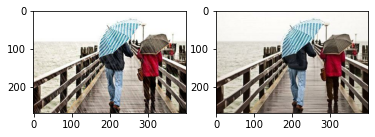

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[1].imshow(real/255.0)
ax[0].imshow(fake/255.0)
plt.show()

In [8]:
def resize(image_input,image_real,h,w):
  image_input = tf.image.resize(image_input,(h,w),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image_real = tf.image.resize(image_real,(h,w),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image_input, image_real

(268, 400, 3)
(256, 256, 3)
(256, 256, 3)


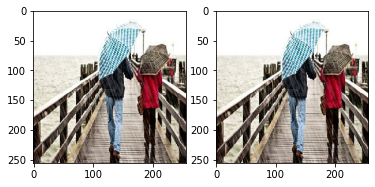

In [9]:
print(fake.shape)
fake, hhhhh= resize(fake,fake,256,256)
print(fake.shape)
print(hhhhh.shape)
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[1].imshow(hhhhh/255.0)
ax[0].imshow(fake/255.0)
#plt.show()

In [10]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image],axis=0)
  cropped_image = tf.image.random_crop(stacked_image,size=(2,IMG_HEIGHT,IMG_WIDTH,3))
  return cropped_image[0], cropped_image[1]

In [11]:
def normalize(input_image, real_image):
  input_image = input_image/(255/2) - 1
  real_image = real_image/(255/2) - 1
  return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image,real_image):
  input_image, real_image = resize(input_image, real_image,286,286) # resizing to 286 x 286 x 3
  input_image, real_image = random_crop(input_image, real_image) # randomly cropping to 256 x 256 x 3
  if np.random.uniform()>0.5: # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image

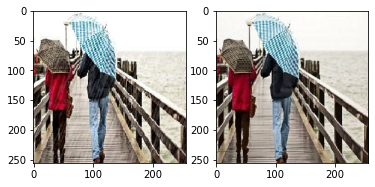

In [13]:
#real, fake = tf.map_fn(lambda path: load(path),path_to_im,)
in_im,re_im = random_jitter(fake, real)
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[1].imshow(re_im/255.0)
ax[0].imshow(in_im/255.0)
#plt.show()

In [14]:
def load_train(image_path):
  input_image, real_image = load(image_path)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

def load_test(image_path):
  input_image, real_image = load(image_path)
  input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

def load_validation(image_path):
  return load_test(image_path)

In [15]:
train_data = tf.data.Dataset.list_files('rain/rain/training/*.jpg')
train_data = train_data.map(load_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_data = train_data.shuffle(BATCH_SIZE).batch(BATCH_SIZE)

vali_data = tf.data.Dataset.list_files('rain/rain/test_syn/*.jpg')
vali_data = vali_data.map(load_test)
vali_data = vali_data.batch(BATCH_SIZE)

test_data = tf.data.Dataset.list_files('rain/rain/val/*.jpg')
test_data = test_data.map(load_test)
test_data = test_data.batch(BATCH_SIZE)

In [16]:
def down_sample(filters,size,apply_batchNorm=True):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',
                                    kernel_initializer=tf.random_normal_initializer(0.,0.02),
                                    use_bias=False))
  if apply_batchNorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [17]:
def up_sample(filters,size,apply_dropOut=False):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
  result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=1,padding='same',
                                    kernel_initializer=tf.random_normal_initializer(0.,0.02),
                                    use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropOut:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [18]:
def Generator():
  print("hi")
  inputs = tf.keras.layers.Input(shape=(256,256,3))

  down_stack = [down_sample(64,4,apply_batchNorm=False), # (bs, 128, 128, 64)
                down_sample(128,4), # (bs, 64, 64, 128)
                down_sample(256,4), # (bs, 32, 32, 256)
                down_sample(512,4), # (bs, 16, 16, 512)
                down_sample(512,4), # (bs, 8, 8, 512)
                down_sample(512,4), # (bs, 4, 4, 512)
                down_sample(512,4), # (bs, 2, 2, 512)
                down_sample(512,4)] # (bs, 1, 1, 512)

  up_stack = [up_sample(512,4,apply_dropOut=True), # (bs, 2, 2, 1024)
                up_sample(512,4,apply_dropOut=True), # (bs, 4, 4, 1024)
                up_sample(512,4,apply_dropOut=True), # (bs, 8, 8, 1024)
                up_sample(512,4), # (bs, 16, 16, 1024)
                up_sample(256,4), # (bs, 32, 32, 512)
                up_sample(128,4), # (bs, 64, 64, 256)
                up_sample(64,4), # (bs, 128, 128, 128)
                ]
  last = tf.keras.layers.Conv2DTranspose(3,4,strides=2,padding='same',
                                           kernel_initializer=tf.random_normal_initializer(0.,0.02),
                                           activation='tanh')
  
  x = inputs
  skip_connections = []
  for layer in down_stack:
    x = layer(x)
    skip_connections.append(x)
  
  skip_connections = reversed(skip_connections[:-1])

  for layer, u_net in zip(up_stack,skip_connections):
    x = layer(x)
    x = tf.keras.layers.Concatenate()([x, u_net])

  out = last(x)

  return tf.keras.Model(inputs=inputs,outputs=out)
  

In [19]:
generator = Generator()
#tf.keras.utils.plot_model(generator,show_shapes=True,dpi=100)

hi


In [20]:
print(fake.shape)

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


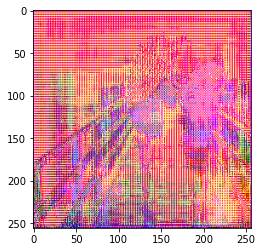

In [21]:
gen_output = generator(fake[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [22]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from skimage.metrics import structural_similarity as ssim
model=VGG16(weights='imagenet',include_top=False)

class contentLoss():
    def __init__(self):
        super().__init__()
        for layer in model.layers:
            layer.trainable=False

    def forward(self,reconstructed,reference):
        #layer_outputs = [layer.output for layer in model.layers]
        #reconstructed=tf.keras.backend.expand_dims(reconstructed,axis=-1)
        #print(type(reconstructed))
        #print("reconstructed")
        #print(reconstructed.shape)
        rec_feats=(model(inputs=reconstructed))
        rec_feats=tf.squeeze(rec_feats)
        #reference=tf.keras.backend.expand_dims(reference,axis=-1)
        ref_feats=(model(inputs=reference))
        ref_feats=tf.squeeze(ref_feats)
        #print(rec_feats)
        #print(ref_feats)
        #mse= tf.keras.losses.MeanSquaredError()
        loss_val=tf.image.ssim(ref_feats,rec_feats,max_val=1.,filter_size=1)
        return 1-loss_val

In [23]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  percep_loss=contentLoss().forward(gen_output,target) 
  #print(type(ref_feats))
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  print(gan_loss,l1_loss,percep_loss)
  total_gen_loss = gan_loss + (LAMBDA * (l1_loss + percep_loss))

  return total_gen_loss, gan_loss, l1_loss

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = down_sample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = down_sample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = down_sample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [25]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([ 1 30 30  1], shape=(4,), dtype=int32)


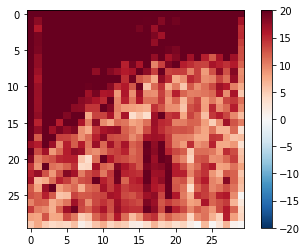

In [26]:
disc_out = discriminator([fake[tf.newaxis,...], gen_output], training=False)
print(type(disc_out))
print(tf.shape(disc_out))
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, "ckpt")
checkpoint_prefix = 'checkpoint/ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=2)

checkpoint.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
  print("Restaurado de {}".format(ckpt_manager.latest_checkpoint))
else:
  print("Inicializando desde cero.")

Inicializando desde cero.


In [31]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


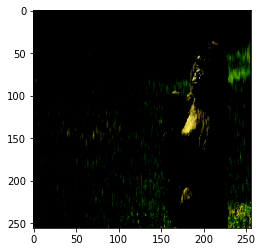

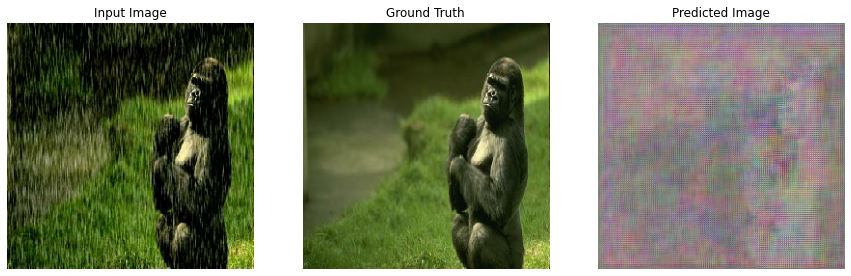

In [32]:
for example_input, example_target in test_data.take(1):
  plt.imshow(example_input[0])
  plt.show()
  generate_images(generator, example_input, example_target)

In [33]:
EPOCHS = 101
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [34]:
@tf.function
def train_step(input_image, target, epoch):
  #print(type(input_image))
  #print(input_image.shape)
  #print(type(target))
  #print(target.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  #with summary_writer.as_default():
   # tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    #tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
   # tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    #tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [35]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      #print(type(input_image))
      #print(input_image.shape)
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [39]:
#%load_ext tensorboard
#%tensorboard --logdir {log_dir}

In [40]:
print(train_data.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


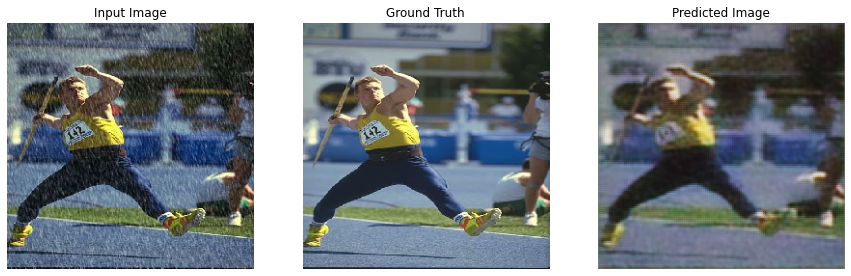

Epoch:  2
.Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32) Tensor("Mean_3:0", shape=(), dtype=float32) Tensor("sub_4:0", shape=(32,), dtype=float32)
...................Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32) Tensor("Mean_3:0", shape=(), dtype=float32) Tensor("sub_4:0", shape=(2,), dtype=float32)


In [ ]:
fit(train_data, EPOCHS, vali_data)

In [ ]:
#!tensorboard dev upload --logdir  {log_dir}

In [ ]:
#display.IFrame(
#    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#    width="100%",
#    height="1000px")

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint("/content/drive/My Drive/Colab Notebooks/IDCGAN_Github/Single-Image-De-Raining-Keras/dataset/checkpoint/"))

0.7347829840289742


TypeError: Invalid shape (32, 256, 256, 3) for image data

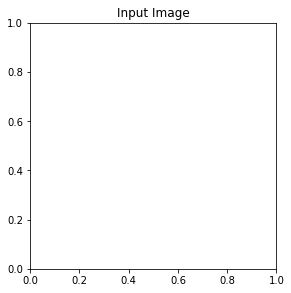

In [36]:
checkpoint.restore(tf.train.latest_checkpoint("checkpoint"))
from skimage.metrics import structural_similarity as ssim
for inp, tar in test_data.take(20):
    prediction = generator(inp, training = True)
    tarn = np.squeeze(tar.numpy())
    predictionn = np.squeeze(prediction.numpy())
    inpn = np.squeeze(inp.numpy())
    res = ssim(tarn,predictionn, multichannel = True)
    plt.figure(figsize=(15,15))
    print(res)

    display_list = [inpn, tarn, predictionn]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()